# Results and Analysis

## Hierarchical Classification: Architecture Comparison

### Evaluation metrics: **Accuracy, Precision, Recall, F1-Score, AUC, ROC Curves**

In [1]:
import sys
sys.path.insert(0, '..')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset, REGION_FINE_CLASS_COUNTS
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Test Data

In [2]:
# Load test data
train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Test samples: {dataset_info['test_samples']}")
print(f"Regions: {dataset_info['idx_to_region']}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and 

## 2. Discover Available Hierarchical Models

In [3]:
ARCHITECTURES = ['enhanced', 'resnet18_3d', 'resnet34_3d', 'densenet121_3d', 'efficientnet3d_b0']

hierarchical_models = {}

print("Scanning for trained hierarchical models...")
print("-" * 50)

for arch in ARCHITECTURES:
    model_path = f"{PATHS['models']}/hierarchical_{arch}.pth"
    if os.path.exists(model_path):
        hierarchical_models[arch] = torch.load(model_path, map_location=DEVICE)
        print(f"Found: hierarchical_{arch}.pth")

print("-" * 50)
print(f"Models found: {list(hierarchical_models.keys())}")

Scanning for trained hierarchical models...
--------------------------------------------------


/tmp/ipykernel_8833/425222008.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hierarchical_models[arch] = torch.load(model_path, map_location=DEVICE)


Found: hierarchical_resnet18_3d.pth
--------------------------------------------------
Models found: ['resnet18_3d']


In [4]:
# Load hierarchical model
def compute_metrics(y_true, y_pred, y_proba=None, num_classes=None):
    """Compute accuracy, precision, recall, F1, and AUC."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }
    
    # AUC (requires probability scores and multi-class handling)
    if y_proba is not None and num_classes is not None and num_classes > 1:
        try:
            if num_classes == 2:
                metrics['auc'] = roc_auc_score(y_true, y_proba[:, 1])
            else:
                y_true_bin = label_binarize(y_true, classes=range(num_classes))
                metrics['auc'] = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')
        except Exception as e:
            metrics['auc'] = None
    else:
        metrics['auc'] = None
    
    return metrics

# Compute metrics for each architecture
all_metrics = {}

for arch, checkpoint in hierarchical_models.items():
    results = checkpoint['test_results']
    
    # Coarse (Stage 1) metrics
    coarse_metrics = compute_metrics(
        results['coarse_labels'],
        results['coarse_predictions'],
        num_classes=len(dataset_info['idx_to_region'])
    )
    
    # Fine (Stage 2) metrics  
    fine_metrics = compute_metrics(
        results['fine_labels'],
        results['fine_predictions']
    )
    
    all_metrics[arch] = {
        'coarse': coarse_metrics,
        'fine': fine_metrics,
        'per_region': results['fine_accuracy_per_region']
    }

In [5]:
print("\n" + "="*100)
print("HIERARCHICAL MODEL COMPARISON - STAGE 1 (COARSE/REGION)")
print("="*100)

print(f"\n{'Architecture':<18} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<12}")
print("-" * 100)

for arch in ARCHITECTURES:
    if arch not in all_metrics:
        continue
    m = all_metrics[arch]['coarse']
    auc_str = f"{m['auc']:.4f}" if m['auc'] else "N/A"
    print(f"{arch:<18} {m['accuracy']:<12.4f} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1']:<12.4f} {auc_str:<12}")

print("\n" + "="*100)
print("HIERARCHICAL MODEL COMPARISON - STAGE 2 (FINE/PATHOLOGY)")
print("="*100)

print(f"\n{'Architecture':<18} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 100)

for arch in ARCHITECTURES:
    if arch not in all_metrics:
        continue
    m = all_metrics[arch]['fine']
    print(f"{arch:<18} {m['accuracy']:<12.4f} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1']:<12.4f}")

print("-" * 100)


HIERARCHICAL MODEL COMPARISON - STAGE 1 (COARSE/REGION)

Architecture       Accuracy     Precision    Recall       F1-Score     AUC         
----------------------------------------------------------------------------------------------------
resnet18_3d        0.9598       0.9605       0.9598       0.9598       N/A         

HIERARCHICAL MODEL COMPARISON - STAGE 2 (FINE/PATHOLOGY)

Architecture       Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
resnet18_3d        0.5962       0.5249       0.5962       0.5031      
----------------------------------------------------------------------------------------------------


## 3. Results Comparison

In [6]:
print("\n" + "="*100)
print("FINE ACCURACY PER ANATOMICAL REGION")
print("="*100)

print(f"\n{'Architecture':<18} {'Abdomen':<15} {'Chest':<15} {'Brain':<15}")
print("-" * 100)

for arch in ARCHITECTURES:
    if arch not in all_metrics:
        continue
    pr = all_metrics[arch]['per_region']
    print(f"{arch:<18} {pr.get('abdomen', 0):<15.4f} {pr.get('chest', 0):<15.4f} {pr.get('brain', 0):<15.4f}")


FINE ACCURACY PER ANATOMICAL REGION

Architecture       Abdomen         Chest           Brain          
----------------------------------------------------------------------------------------------------
resnet18_3d        0.4707          0.5799          0.8874         


## 4. Training Curves Comparison

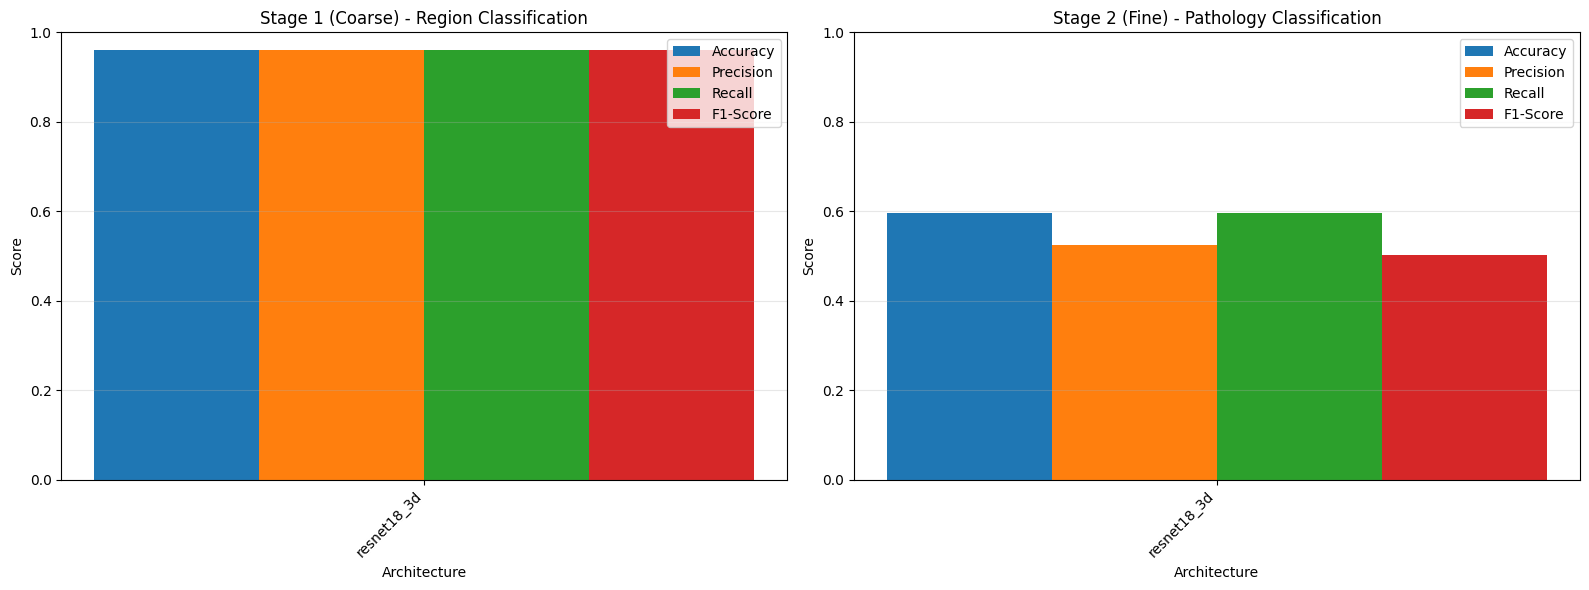

In [7]:
if all_metrics:
    archs = list(all_metrics.keys())
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    x = np.arange(len(archs))
    width = 0.2
    
    # Stage 1 (Coarse) metrics
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
        values = [all_metrics[a]['coarse'][metric] for a in archs]
        axes[0].bar(x + i*width, values, width, label=metrics_names[i])
    
    axes[0].set_xlabel('Architecture')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Stage 1 (Coarse) - Region Classification')
    axes[0].set_xticks(x + width*1.5)
    axes[0].set_xticklabels(archs, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Stage 2 (Fine) metrics
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
        values = [all_metrics[a]['fine'][metric] for a in archs]
        axes[1].bar(x + i*width, values, width, label=metrics_names[i])
    
    axes[1].set_xlabel('Architecture')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Stage 2 (Fine) - Pathology Classification')
    axes[1].set_xticks(x + width*1.5)
    axes[1].set_xticklabels(archs, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{PATHS['figures']}/metrics_comparison.png", dpi=150)
    plt.show()

## 5. Confusion Matrices


 ROC Curves for Best Model: resnet18_3d


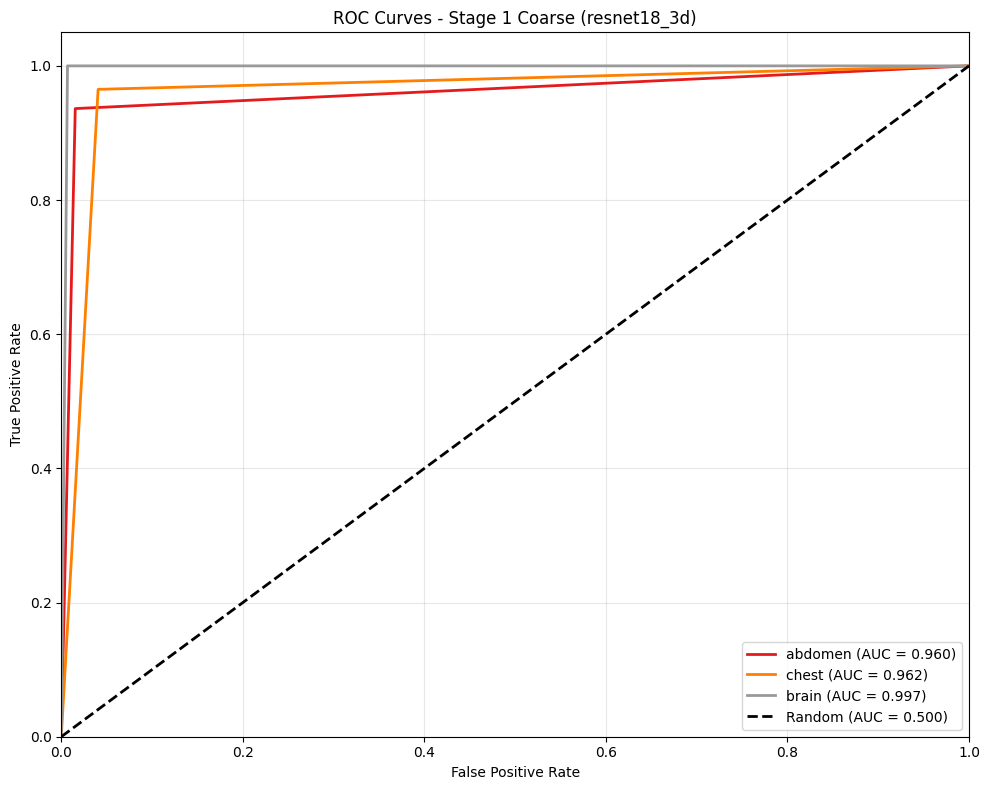

In [8]:
def plot_roc_curves(y_true, y_pred, class_names, title, save_path):
    """Plot ROC curves for multi-class classification."""
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    y_pred_bin = label_binarize(y_pred, classes=range(n_classes))
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

if all_metrics:
    # Find best model
    best_arch = max(all_metrics.keys(), key=lambda a: all_metrics[a]['fine']['f1'])
    results = hierarchical_models[best_arch]['test_results']
    
    print(f"\n ROC Curves for Best Model: {best_arch}")
    
    # Coarse ROC
    region_labels = [dataset_info['idx_to_region'][i] for i in range(len(dataset_info['idx_to_region']))]
    plot_roc_curves(
        results['coarse_labels'],
        results['coarse_predictions'],
        region_labels,
        f'ROC Curves - Stage 1 Coarse ({best_arch})',
        f"{PATHS['figures']}/roc_coarse_{best_arch}.png"
    )

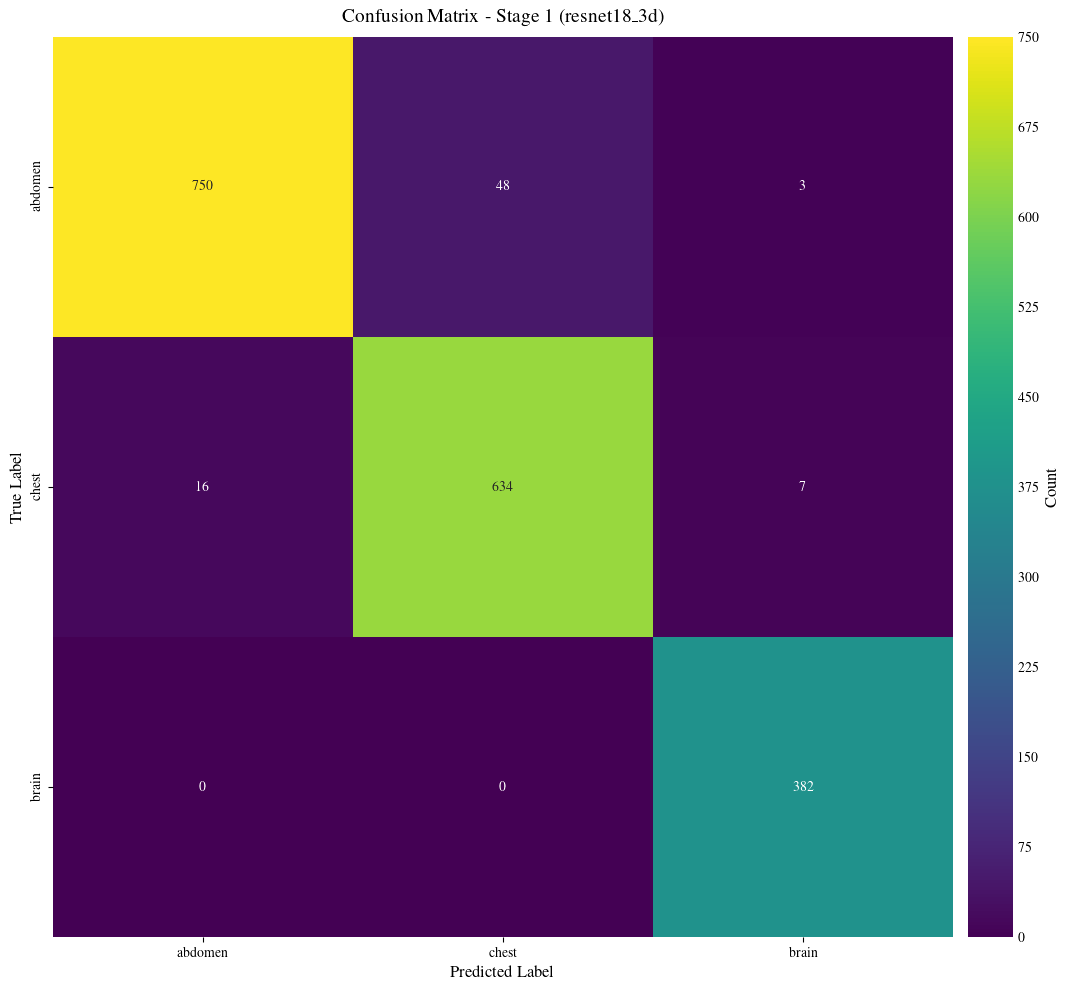

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({
    "pgf.texsystem": "pdflatex", 
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"], 
    "pgf.rcfonts": False,
    "pgf.preamble": r"\usepackage{times}\usepackage{amsmath}", 
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.size": 10,
})

def plot_confusion_matrix(y_true, y_pred, title, labels=None, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = len(cm)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    hm = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
        square=True,
        cbar=False,
        linewidths=0,
        annot_kws={"size": 10}
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    
    # Add custom colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    vmin = cm.min()
    vmax = cm.max()
    cbar = fig.colorbar(
        hm.collections[0], 
        cax=cax,
        drawedges=False,
        ticks=np.linspace(vmin, vmax, 11)
    )
    cbar.solids.set_edgecolor("face")
    cbar.solids.set_rasterized(False)
    cbar.set_label("Count", fontsize=12)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(size=0, labelsize=10)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold", labelpad=4)
    ax.set_ylabel("True Label", fontsize=12, fontweight="bold", labelpad=4)
    
    # Disable rasterization for all artists
    for artist in fig.findobj():
        if hasattr(artist, "set_rasterized"):
            artist.set_rasterized(False)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05, dpi=150)
    
    plt.show()

# Usage with your original code
if all_metrics:
    best_arch = max(all_metrics.keys(), key=lambda a: all_metrics[a]['fine']['f1'])
    results = hierarchical_models[best_arch]['test_results']
    
    # Coarse confusion matrix
    region_labels = [dataset_info['idx_to_region'][i] for i in range(len(dataset_info['idx_to_region']))]
    
    plot_confusion_matrix(
        results['coarse_labels'],
        results['coarse_predictions'],
        f'Confusion Matrix - Stage 1 ({best_arch})',
        labels=region_labels,
        save_path=f"{PATHS['figures']}/confusion_coarse_{best_arch}.pgf"
    )

## 6. Summary Table

In [10]:
print("\n" + "="*100)
print("FINAL RANKING BY F1-SCORE")
print("="*100)

sorted_archs = sorted(all_metrics.keys(), key=lambda a: all_metrics[a]['fine']['f1'], reverse=True)

print(f"\n{'Rank':<6} {'Architecture':<18} {'Coarse F1':<12} {'Fine F1':<12} {'Fine Acc':<12}")
print("-" * 60)

for rank, arch in enumerate(sorted_archs, 1):
    m_c = all_metrics[arch]['coarse']
    m_f = all_metrics[arch]['fine']
    print(f"{rank:<6} {arch:<18} {m_c['f1']:<12.4f} {m_f['f1']:<12.4f} {m_f['accuracy']:<12.4f}")

print("-" * 60)

if sorted_archs:
    best = sorted_archs[0]
    m = all_metrics[best]
    print(f"\n BEST MODEL: {best}")
    print(f"   Stage 1 - Accuracy: {m['coarse']['accuracy']:.4f}, F1: {m['coarse']['f1']:.4f}")
    print(f"   Stage 2 - Accuracy: {m['fine']['accuracy']:.4f}, F1: {m['fine']['f1']:.4f}")


FINAL RANKING BY F1-SCORE

Rank   Architecture       Coarse F1    Fine F1      Fine Acc    
------------------------------------------------------------
1      resnet18_3d        0.9598       0.5031       0.5962      
------------------------------------------------------------

 BEST MODEL: resnet18_3d
   Stage 1 - Accuracy: 0.9598, F1: 0.9598
   Stage 2 - Accuracy: 0.5962, F1: 0.5031
